In [61]:
import pandas as pd

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(rc={'figure.figsize':(10,5)}, style="whitegrid", palette='RdBu')

In [62]:
#внешние ссылки
assessments_csv = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
courses_csv = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
studentAssessment_csv = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
studentRegistration = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'

In [63]:
#функция для получения загрузочных ссылок с Яндекс Диска
def get_ds_from_yandex(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df_final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(df_final_url)
    download_url = response.json()['href']
    return download_url

In [64]:
assessments = pd.read_csv(get_ds_from_yandex(assessments_csv))
courses = pd.read_csv(get_ds_from_yandex(courses_csv))
studentAssessment = pd.read_csv(get_ds_from_yandex(studentAssessment_csv))
studentRegistration = pd.read_csv(get_ds_from_yandex(studentRegistration))

## 0. Разведочный анализ данных (EDA)

**assessments** — содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

- code_module — идентификационный код предмета.
- code_presentation — семестр (Идентификационный код).
- id_assessment — тест (Идентификационный номер ассессмента).
- assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
- date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
- weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [65]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [66]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [67]:
assessments.isnull().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [68]:
assessments.query('date.isnull()')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


**courses**— список предметов по семестрам.
- code_module — предмет (идентификационный код).
- code_presentation — семестр (идентификационный код).
- module_presentation_length — продолжительность семестра в днях.

In [69]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [70]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


In [71]:
courses.isnull().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

**studentAssessment**— результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

- id_assessment — тест (идентификационный номер).
- id_student — идентификационный номер студента.
- date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
- is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
- score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [72]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [73]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [74]:
studentAssessment.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

**studentRegistration**— содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

- code_module — предмет (идентификационный код).
- code_presentation — семестр (идентификационный код)
- id_student — идентификационный номер студента.
- date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
- date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [75]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [76]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [77]:
studentRegistration.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

Так как нам предстоит изучить именно экзамены, то следует рассмотреть информацию о них подробнее.

In [78]:
assessments.query('assessment_type=="Exam"')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Смутило наличие двух экзаменов по предмету "CCC" в одном семестре. Есть несколько предположений:  
- Во-первых, в этом курсе и правда два экзамена, но это нелогично, т.к. странно подводить итог (коим является экзамен) посреди семестра. 
- Во-вторых, ошибка в данных: вместо 2014 года должен быть 2013 по аналогии с другими курсами. 
- В-третьих, два разных потока по одному предмету в семестре.

Прежде чем подводить некоторые выводы, следует посмотреть, затронет ли нас эта проблема при анализе. Для этого посмотрим, есть ли эти дубли в таблице с результатами тестов студентов - studentAssessment. 

In [79]:
EDA_studentAssessment = (studentAssessment
                         .merge(assessments.query('assessment_type == "Exam"'), on = 'id_assessment', how='inner')
                         )
(EDA_studentAssessment
 .query('code_module == "CCC"')
 .groupby(['code_presentation', 'id_assessment'], as_index=False)
 .count()[['code_presentation', 'id_assessment']]
 )

,code_presentation,id_assessment
0,2014B,24290
1,2014J,24299


In [80]:
(assessments
 .query('assessment_type == "Exam" & code_module == "CCC"')[['code_presentation', 'id_assessment']]
 )

,code_presentation,id_assessment
62,2014B,24290
63,2014B,40087
72,2014J,24299
73,2014J,40088


В studentAssessment эти дубли не входят, поэтому проблем дальше возникнуть не должно.

Также следует изучить, сколько курсов представлено в таблице studentAssessment из расчета на то, что курсом будем считать конкретный предмет в одном семестре. Например, "BBB-2013B" и "BBB-2013J" - это два разных курса.

In [81]:
(EDA_studentAssessment
 .groupby(['code_module', 'code_presentation'], as_index=False)
 .count()[['code_module', 'code_presentation']]
 )

,code_module,code_presentation
0,CCC,2014B
1,CCC,2014J
2,DDD,2013B
3,DDD,2013J
4,DDD,2014B
5,DDD,2014J


Всего в таблице с результатами тестов студентов представлено 6 курсов (два предмета), что расходится с данными в таблице assessments, где представлено гораздо больше предметов. Причиной рассхождения может быть, например, ошибка при сборе данных или просто предоставление неполных данных.

_______________________________________________________________________________________________________________________________

## 1. Сколько студентов успешно сдали только один курс?
Из условий задачи: успешная сдача — это зачёт по курсу на **экзамене**.

Будем следовать из того, что для успешной сдачи курса надо сдать экзамен от 40 баллов, т.е. **40-100 баллов включительно - это зачет.** 

Следовательно надо найти студентов, которые сдали только один экзамен на 40+ баллов и посчитать их количество (также надо учесть, что это не перезачет (is_banked)).

---

Для начала создадим отдельный датафрейм, где будут находится только результаты экзаменов.
Также создадим колонку, которая будет показывать, получил ли студент зачет.

In [82]:
exam_only = (studentAssessment
             .merge(assessments.query('assessment_type == "Exam"'), on = 'id_assessment', how='inner')
             )
exam_only['result'] = exam_only.score.apply(lambda x: 1 if x >= 40 else 0)
exam_only = exam_only.query('is_banked == 0')

In [83]:
exam_only.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,result
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


In [84]:
(exam_only
 .query('result == 1')
 .groupby('id_student')
 .agg({'id_assessment': 'count'})
 .query('id_assessment == 1').count()
)

id_assessment    3802
dtype: int64

**Таким образом, _3802_ студента успешно сдали только один экзамен, а следовательно и курс.**

_______________________________________________________________________________________________________________________________

## 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.

Для определения сложности экзамена нам нужно найти **CR**, который и будет являться **завершаемостью** - отношением кол-ва успешных экзаменов и кол-вом всех попыток сдать экзамен. Чем больше CR, тем легче экзамен, и наоборот.

----

Так как один курс подразумевает один экзамен, то рассмотрим завершаемость и по предметам, и по курсам.

In [85]:
(exam_only
  .groupby('code_module')
  .agg({'result': 'mean'})
  ).rename(columns = {'result': 'CR'}).reset_index() 

,code_module,CR
0,CCC,0.878851
1,DDD,0.889947


**Завершаемость по предмету DDD (0.889947) ненамного, но выше чем у CCC (0.878851).**
Теперь рассмотрим курсы. 

In [86]:
exam_only_cr = (exam_only
                .groupby(['code_module', 'code_presentation', 'id_assessment'])
                .agg({'id_student': 'count'})
                .rename(columns = {'id_student': 'total_attempts'})
                .reset_index()
               )

In [87]:
exam_only_cr['CR'] = (exam_only
                      .groupby(['code_module', 'code_presentation', 'id_assessment'])
                      .agg({'result': 'mean'}).reset_index()
                      .rename(columns = {'result': 'CR'}).reset_index() 
                      )[['CR']]
exam_only_cr.sort_values('CR', ascending=False)

,code_module,code_presentation,id_assessment,total_attempts,CR
4,DDD,2014B,25361,524,0.925573
3,DDD,2013J,25354,968,0.907025
0,CCC,2014B,24290,747,0.888889
5,DDD,2014J,25368,950,0.886316
1,CCC,2014J,24299,1168,0.872432
2,DDD,2013B,25340,602,0.837209


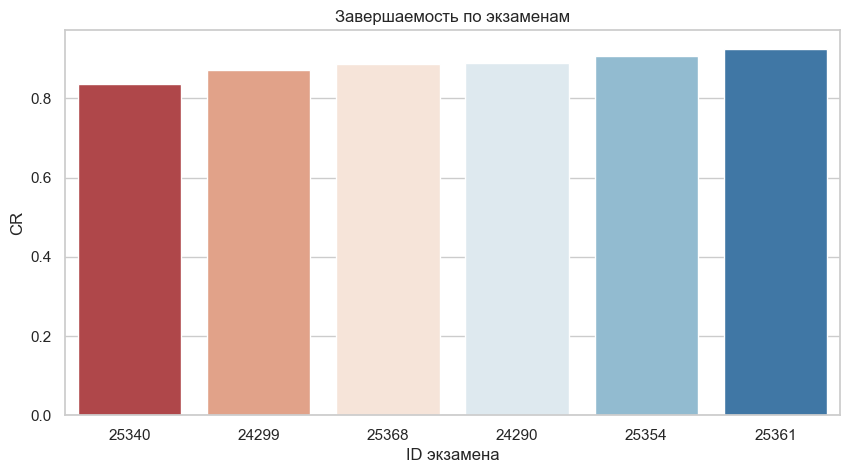

In [88]:
sns.barplot(data = exam_only_cr, 
            x = 'id_assessment', 
            y = 'CR', 
            order=exam_only_cr.sort_values('CR').id_assessment
            )
plt.title('Завершаемость по экзаменам')
plt.xlabel('ID экзамена')
plt.show()

**Самым _сложным_ экзаменом оказался _25340 : курс 'DDD-2013B'_ : CR = 0.837209.**

**Самым _простым_ экзаменом оказался _25361 : курс 'DDD-2014B'_ : CR = 0.925573.**

_______________________________________________________________________________________________________________________________

## 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).
Как было выяснено выше, всего у нас два предмета, по которым есть экзамен. Факт сдачи экзамена - это получение студентом 40+ баллов, т.е. за время сдачи экзамена будем считать только последнюю **успешную** попытку.
Т.к. у нас нет именно даты сдачи экзамена, а только количество дней с начала семестра (date_submitted), то, по сути, мы узнаем среднее количество дней, которое студенты потратили на курс.

Также можно попробовать взять максимальное количество дней с начала семестра у каждого студента, но этот подход не является верным, т.к. у некоторых студентов на максимальное количество дней приходятся баллы меньше 40, т.е. они не стали пересдавать экзамен на нужное количество баллов.

Наглядно посмотрим на максимальное количество дней и соответствующие баллы у каждого студента. Можно заметить, что при максимальном количестве дней с начала семестра у некоторых студентов маленькое количество баллов.

In [89]:
(exam_only
 .groupby(['id_student', 'date_submitted', 'score'], as_index=False)
 .agg({'date_submitted': 'max'})
 .sort_values('score').head(10)
)

,id_student,score,date_submitted
77,81351,0.0,248
1837,556660,0.0,235
143,131152,0.0,244
4851,2588543,4.0,236
519,338034,7.0,241
3193,622787,8.0,230
3886,653914,9.0,243
2492,588846,10.0,230
3608,634721,10.0,244
3428,630013,12.0,244


-------------------------------------------------------------------------------------------------------------------------------

In [90]:
exam_only.head(1)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,result
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0


In [91]:
avg_mod_days = (exam_only
                .query('result == 1')
                .groupby('code_module')
                .agg({'date_submitted': 'mean'})
                .round(2)
                .rename(columns = {'date_submitted': 'avg_days'})
                .reset_index()
                )
avg_mod_days

,code_module,avg_days
0,CCC,239.35
1,DDD,237.98


**На экзамен по CCC потрачено в среднем _239.35_ дней.**

**На экзамен по DDD потрачено в среднем _237.98_ дней.**

_______________________________________________________________________________________________________________________________

## 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).
Для выявления самых популярных предметов нужно посчитать количество уникальных студентов, которые зарегистрировались на них. 

Для выявления предметов с наибольшим оттоком нужно посчитать **CR** - отношение числа тех, кто ушел, и тех, кто зарегистрировался.

---

In [92]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


В агрегировании используется nunique вместо count, чтобы избежать подсчета возможных дублей, т.е. если человек регистрировался на один предмет несколько раз.

In [93]:
student_count_module = (studentRegistration
                        .groupby('code_module', as_index=False)
                        .agg({'id_student': 'nunique'})
                        .rename(columns = {'id_student': 'student_count'})
                        .sort_values('student_count', ascending=False)
                       )
student_count_module

,code_module,student_count
1,BBB,7692
5,FFF,7397
3,DDD,5848
2,CCC,4251
4,EEE,2859
6,GGG,2525
0,AAA,712


In [94]:
# считаем, сколько уникальных студентов ушло с предмета
outflow_count = (studentRegistration
                 .query('date_unregistration.notna()')
                 .groupby('code_module', as_index=False)
                 .agg({'id_student': 'nunique'})
                 .rename(columns = {'id_student': 'outflow_count'})
                 .sort_values('outflow_count', ascending=False)
                )

In [95]:
module_student_stat = student_count_module.merge(outflow_count)
module_student_stat['CR'] = module_student_stat.outflow_count / module_student_stat.student_count 
module_student_stat.sort_values('CR', ascending=False)

,code_module,student_count,outflow_count,CR
3,CCC,4251,1858,0.437074
2,DDD,5848,2065,0.353112
1,FFF,7397,2249,0.304042
0,BBB,7692,2314,0.300832
4,EEE,2859,693,0.242392
6,AAA,712,116,0.162921
5,GGG,2525,287,0.113663


**Топ-3 предмета по популярости: _BBB, FFF, DDD_**

**Топ-3 предмета по оттоку: _CCC, DDD, FFF_**

При этом больше всего человек ушли с BBB, FFF, DDD	

_______________________________________________________________________________________________________________________________

## 5. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 
Как было обусловлено выше, сдать курс - это значит получить зачет за экзамен.
Работать следует аналогично заданиям №2 и №3, только с паправкой на семестр.
Всего у нас 4 семеста, которые как раз покрывают 2013 и 2014 годы.

---

In [96]:
exam_only.head(1)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,result
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0


In [97]:
exam_only.code_presentation.value_counts()

code_presentation
2014J    2118
2014B    1271
2013J     968
2013B     602
Name: count, dtype: int64

Посмотрим завершаемось. Как и в задании №2 нам нужно найти CR. Чем ниже CR, тем ниже завершаемость.

In [98]:
completeness = (exam_only
                .groupby('code_presentation')
                .agg({'result': 'mean'})
                .rename(columns = {'result': 'CR'})
                .reset_index()
                )
completeness.sort_values('CR', ascending=False)

,code_presentation,CR
1,2013J,0.907025
2,2014B,0.904013
3,2014J,0.878659
0,2013B,0.837209


Посмотрим сроки сдачи курсов. 

In [99]:
avg_term_days = (exam_only
                 .query('result == 1')
                 .groupby(['code_presentation'])
                 .agg({'date_submitted': 'mean'})
                 .round(2)
                 .rename(columns = {'date_submitted': 'avg_days'})
                 .reset_index()
                )
avg_term_days.sort_values('avg_days', ascending=False)

,code_presentation,avg_days
3,2014J,243.68
1,2013J,239.51
2,2014B,233.00
0,2013B,230.16


**Семестр с самой низкой завершаемостью: 2013B**

**Семестр с самым долгим средним сроком сдачи курсов: 2014J**

_______________________________________________________________________________________________________________________________

## 6. Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

В адаптированной кластеризации можно выбрать следующие метрики: 

**R - среднее время сдачи одного экзамена,**

**F - завершаемость курсов,**

**M - среднее количество баллов, получаемое за экзамен.**


Все сегменты связаны с экзаменом, поэтому будем использовать данные exam_only.

Стоит обозначить, что в анализе также будут присутствовать данные о студентах, которые дошли до этапа экзамена, но они не обязательно его сдали.

---

In [100]:
exam_only.head(1)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,result
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0


Сначала сгруппируем данные по студентам и посчитаем, сколько экзаменов каждый сдал и сколько попыток было.
Таким образом мы получим завершаемость (отношение кол-ва успешных экзаменов и кол-ва всех попыток)

In [101]:
F = (exam_only
     .groupby('id_student')
     .agg({"id_student": 'count', 'result': 'sum'})
     .rename(columns = {'id_student': 'tries', 'result': 'passed'})
    )
F['Frequency'] = F.passed / F.tries

In [102]:
F.sort_values('Frequency').Frequency.unique()

array([0. , 0.5, 1. ])

Всего мы получили 3 значения завершаемости = [0. , 0.5, 1. ]

По аналогии с заданием №3 узнаем сколько дней студент в среднем потратил на курс. 
Также получим среднее количество баллов.

In [103]:
aggr = {
    'date_submitted': 'mean',
    'score': 'mean'
        }

RM = (exam_only
     .groupby('id_student', as_index=False)
     .agg(aggr)
     .rename(columns = {'date_submitted': 'Recency', 'score': 'Monetary'})
    )

Теперь объединим полученные результаты в одну таблицу и скорректируем ее, оставив только нужные колонки.

In [104]:
RFM = F.merge(RM, how = 'left', on = 'id_student')
RFM = RFM[['id_student', 'Recency', 'Frequency', 'Monetary']]
RFM.head()

,id_student,Recency,Frequency,Monetary
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


Далее проведем кластеризацию. Так как присутствует только 3 значения для завершаемости, то для сегментации также логично брать 3 значения.

**Recency (R) - среднее количество дней, потраченное на курсы:**

Посмотрим на распределение по децилям и на график распределения среднего времени, потраченого на курсы. Можно выделить 3 зоны: примерно до 240, которая характеризуется колебаниями; от 240 до ~250, где показатели стабильно высокие; более 250 с самыми низкими показателями. Эти данные и будут сигментами.

- 1: менее 240 дней
- 2: от 240 до 250 дней
- 3: более 250 дней 

In [105]:
r = RFM['Recency'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]).to_frame().reset_index()
r = r.rename(columns={'index':'q'}).astype({'q':'str'})
r

,q,Recency
0,0.1,230.0
1,0.2,231.0
2,0.3,234.0
3,0.4,237.0
4,0.5,241.0
5,0.6,242.0
6,0.7,243.0
7,0.8,243.5
8,0.9,244.0
9,1.0,285.0


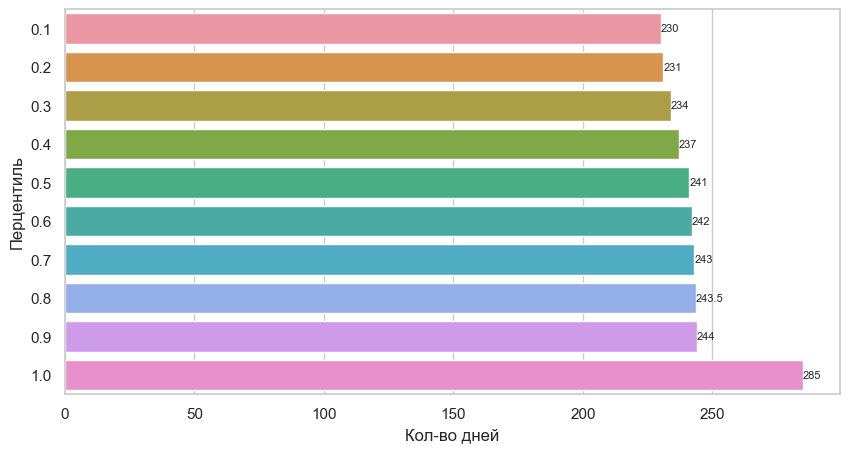

In [106]:
ax = sns.barplot(data=r, y='q', x='Recency')
ax.bar_label(ax.containers[0], fontsize=8)
plt.ylabel('Перцентиль')
plt.xlabel('Кол-во дней')
plt.show()

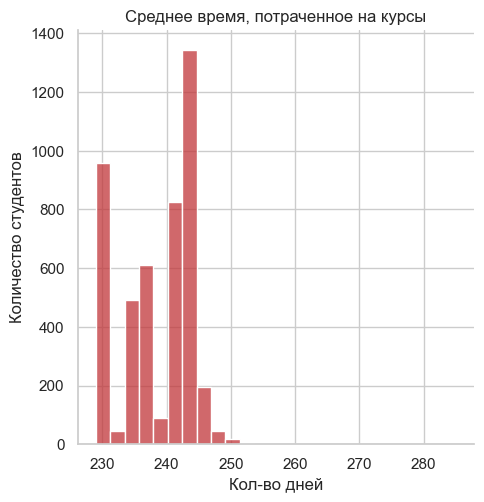

In [107]:
sns.displot(data = RFM, x = 'Recency', bins = 25)
plt.title('Среднее время, потраченное на курсы')
plt.xlabel('Кол-во дней')
plt.ylabel('Количество студентов')
plt.show()

Выявлено 3 значения завершаемости, которые мы и возьмем для кластеризации.

**Frequency (F) - завершаемость курсов:**

- 1: 1
- 2: 0.5
- 3: 0

Для кластеризации среднего количества баллов возьмем условия задания, где балл меньше 40 - незачет, и стандартное распределение баллов в университете с некоторым упрощением (без оценки "удовлетворительно")

**Monetary (M) - среднее количество баллов, получаемое за экзамен:**

- 1: 80 и более - отлично
- 2: 40-80 - хорошо
- 3: менее 40 - незачет

In [108]:
# напишем функцию для распределения сегментов в кластерах

def time(t):
    if t < 240:
        return 1
    elif t >= 250:
        return 3
    else:
        return 2
def completion(c):
    if c == 1:
        return 1
    elif c == 0.5:
        return 2
    else:
        return 3
def score(s):
    if s >= 80:
        return 1
    elif s < 40:
        return 3
    else:
        return 2

In [109]:
RFM['R'] = RFM['Recency'].apply(lambda t: time(t))
RFM['F'] = RFM['Frequency'].apply(lambda c: completion(c))
RFM['M'] = RFM['Monetary'].apply(lambda s: score(s))
RFM['RFM'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM

,id_student,Recency,Frequency,Monetary,R,F,M,RFM
0,23698,243.0,1.0,80.0,2,1,1,211
1,24213,236.0,1.0,58.0,1,1,2,112
2,27116,243.0,1.0,96.0,2,1,1,211
3,28046,237.0,1.0,40.0,1,1,2,112
4,28787,243.0,1.0,44.0,2,1,2,212
...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,1,1,2,112
4629,2694933,230.0,1.0,73.0,1,1,2,112
4630,2695608,237.0,1.0,73.0,1,1,2,112
4631,2697181,230.0,1.0,80.0,1,1,1,111


In [110]:
RFM.RFM.nunique()

13

In [111]:
RFM.RFM.value_counts().sort_index()

RFM
111     568
112    1326
122      13
123       4
133     247
211     730
212    1416
222       8
223       3
233     287
311      15
312      14
333       2
Name: count, dtype: int64

Всего 13 кластеров.

Далее сегментируем студентов по характерстикам.

**R:**

- 1: опережающий (также это те студенты, которые поняли, что не смогут сдать экзамен и решили не пытаться дальше)
- 2: оптимально учащийся (та же ситуация)
- 3: запаздывающий

**F:**

- 1: завешивший все
- 2: завешивший половину
- 3: незавершивший 

**M:**

- 1: отличник
- 2: хорошист
- 3: отстающий

In [112]:
def time(t):
    if t == 1:
        return 'опережающий '
    elif t == 2:
        return 'оптимально учащийся '
    else:
        return 'запаздывающий '
def completion(c):
    if c == 1:
        return 'завершивший все'
    elif c == 2:
        return 'завершивший половину'
    else:
        return 'незавершивший'
def score(s):
    if s == 1:
        return ' отличник'
    elif s == 2:
        return ' хорошист'
    else:
        return ' отстающий'

In [113]:
RFM['Characteristic'] = (RFM['R'].apply(lambda t: time(t)) + 
                         RFM['F'].apply(lambda c: completion(c)) + 
                         RFM['M'].apply(lambda s: score(s))
                         )
RFM.head()

,id_student,Recency,Frequency,Monetary,R,F,M,RFM,Characteristic
0,23698,243.0,1.0,80.0,2,1,1,211,оптимально учащийся завершивший все отличник
1,24213,236.0,1.0,58.0,1,1,2,112,опережающий завершивший все хорошист
2,27116,243.0,1.0,96.0,2,1,1,211,оптимально учащийся завершивший все отличник
3,28046,237.0,1.0,40.0,1,1,2,112,опережающий завершивший все хорошист
4,28787,243.0,1.0,44.0,2,1,2,212,оптимально учащийся завершивший все хорошист


In [114]:
RFM.dtypes

id_student          int64
Recency           float64
Frequency         float64
Monetary          float64
R                   int64
F                   int64
M                   int64
RFM                object
Characteristic     object
dtype: object

In [115]:
#посчитаем количество студентов в каждом кластере
(RFM
 .groupby(['Characteristic', 'RFM'], as_index=False)
 .agg({'id_student': 'count'})
 .rename(columns = {'id_student': 'student_count'})
 .sort_values('student_count', ascending=False)
)

,Characteristic,RFM,student_count
9,оптимально учащийся завершивший все хорошист,212,1416
4,опережающий завершивший все хорошист,112,1326
8,оптимально учащийся завершивший все отличник,211,730
3,опережающий завершивший все отличник,111,568
12,оптимально учащийся незавершивший отстающий,233,287
7,опережающий незавершивший отстающий,133,247
0,запаздывающий завершивший все отличник,311,15
1,запаздывающий завершивший все хорошист,312,14
6,опережающий завершивший половину хорошист,122,13
11,оптимально учащийся завершивший половину хорошист,222,8


Объединим кластеры на логические группы:
- 111 - Лучшие из лучших
- 112, 211, 212 - Умнички
- 311, 312 - Молодцы, но нужно быть порасторопнее
- 122, 222 - Хорошо постарались, но есть к чему стремиться
- 133, 123, 223, 233 - Поняли, что курс не их
- 333 - Они пытались

In [116]:
def group(rfm):
    if rfm in ['111']:
        return 'Лучшие из лучших'
    elif rfm in ['112', '211', '212']:
        return 'Умнички'  
    elif rfm in ['311', '312']:
        return 'Молодцы, но нужно быть порасторопнее'
    elif rfm in ['122', '222']:
        return 'Хорошо постарались, но есть к чему стремиться' 
    elif rfm in ['133', '123', '223', '233']:
        return 'Поняли, что курс не их'
    else:
        return 'Они пытались'           
      

In [117]:
RFM['Group'] = RFM['RFM'].apply(lambda rfm: group(rfm))
RFM.head()

,id_student,Recency,Frequency,Monetary,R,F,M,RFM,Characteristic,Group
0,23698,243.0,1.0,80.0,2,1,1,211,оптимально учащийся завершивший все отличник,Умнички
1,24213,236.0,1.0,58.0,1,1,2,112,опережающий завершивший все хорошист,Умнички
2,27116,243.0,1.0,96.0,2,1,1,211,оптимально учащийся завершивший все отличник,Умнички
3,28046,237.0,1.0,40.0,1,1,2,112,опережающий завершивший все хорошист,Умнички
4,28787,243.0,1.0,44.0,2,1,2,212,оптимально учащийся завершивший все хорошист,Умнички


In [118]:
rfm_group = (RFM
                .groupby('Group', as_index=False)
                .agg({'id_student':'count'})
                .rename(columns={'id_student':'student_count'})
                .sort_values('student_count') 
                )
rfm_group

,Group,student_count
2,Они пытались,2
5,"Хорошо постарались, но есть к чему стремиться",21
1,"Молодцы, но нужно быть порасторопнее",29
3,"Поняли, что курс не их",541
0,Лучшие из лучших,568
4,Умнички,3472


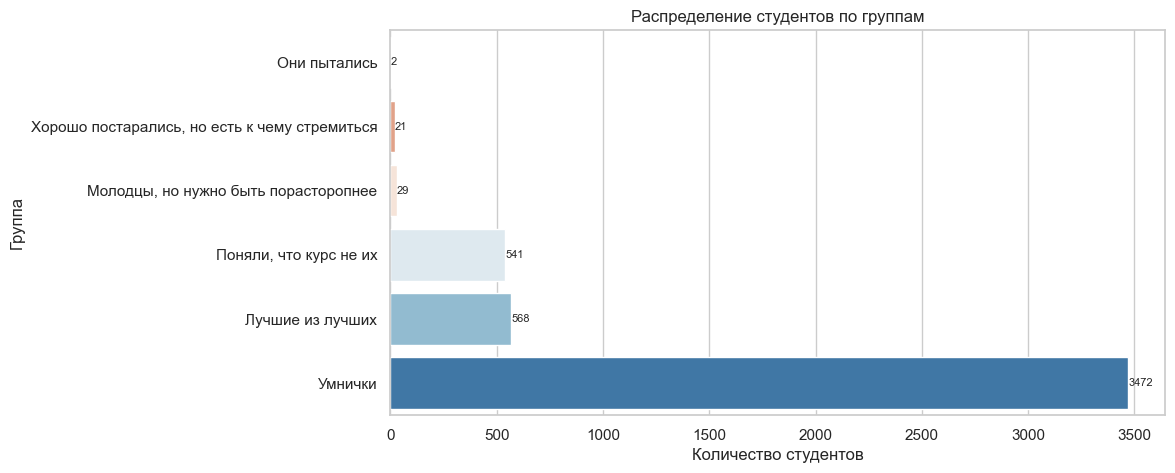

In [119]:
ax = sns.barplot(data=rfm_group, y='Group', x='student_count')
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('Распределение студентов по группам')
plt.xlabel('Количество студентов')
plt.ylabel('Группа')
plt.show()